In [1]:

import collections
from collections import deque
from collections import OrderedDict
from pathlib import PurePosixPath, PureWindowsPath
from purl import URL
from pprint import pprint as pp
import multiprocessing
import concurrent.futures
import datetime
import itertools 
import sys
print(sys.version)

from utils.utils import *
from utils.indicators import *

import pandas_ta as ta
import re
from datetime import datetime, timedelta, date

from scipy import stats
import statsmodels.api as sm
import talib # pip install TA-Lib

import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import *
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


import shutil


import pandas as pd
from sklearn import preprocessing

from matplotlib import pyplot as plt
import plotly.graph_objects as go
from IPython import display, get_ipython

import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore')



from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

# free_gpu_cache()    

# seeds

SEED = 1

import os
os.environ['PYTHONHASHSEED'] = str(SEED)

import random
random.seed(SEED)

import numpy as np
np.seterr(divide = 'ignore')
# np.seterr(divide = 'warn')

rng = np.random.default_rng(SEED) 
ss = rng.bit_generator._seed_seq # use for multiprocessing



SEED_states_log = []



torch.manual_seed(1);  # for reproducibility


3.10.11 (main, Apr  9 2023, 03:52:41) [GCC 12.2.1 20230201]


In [2]:
ticker= (

    'BTCUSD' 

)



res = 'Day'
# res = 'Week'
# res = 'Month'
# res = 'Quarter'
# res = 'Year'

exportPath = './export/'
marketPath = './market/'
imgPath = './image/'
tmpPath = './tmp/'



# --------------------------------------------------------------------------------------------------------------------------------------------
_df = pd.read_csv(marketPath + ticker + '.csv',parse_dates = True,index_col=0)
# _df = _df.tail(500)
if ticker == 'AMPL':
    _df = _df
else:
    _df = _df[:-1] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    # _df = _df
    
if res == 'Day':
    _df = _df.resample('D').mean() 
elif res == 'Week':
    _df = _df.resample('W-MON').mean()    
elif res == 'Month':
    _df = _df.resample('MS').first()
elif res == 'Quarter':
    _df = _df.resample('Q').mean()    
elif res == 'Year':
    _df = _df.resample('Y').mean() 


if ticker == 'AMPL':
    # _df = _df.rename(columns={
    # "open": "open_price", 
    # "high": "high_price", 
    # "low": "low_price", 
    # "close": "close_price"})


    # _df['open']  = _df['Market Cap'] * _df['open_price'] 
    # _df['high']  = _df['Market Cap'] * _df['high_price'] 
    # _df['low']   = _df['Market Cap'] * _df['low_price']  
    # _df['close'] = _df['Market Cap'] * _df['close_price']

    _df['y'] = _df['Market Cap']
    # _df['y'] = _df['close_price']
    # _df['y'] = _df['close']
else:    #-----------------------------------------------------------------------------CHANGE ME------------------------------------------------------------------------------------------------------------------
    # _df['y'] = _df.iloc[:, 0]
    _df['y'] = _df['close']
    # _df['y'] = _df['fires']
    # _df['y'] = _df['acres']
    

idf = _df.interpolate(method='linear', limit_direction='both')

rmssd_data = rmssd(idf['y']).rename("rmssd")
lnrmssd_data = lnrmssd(idf['y']).rename("lnrmssd")
# lhea_data = LHEA(idf.high, idf.low, 10).rename("lhea")
# rema_data = reverse_ema(idf['y'])
gs_data = gann_slope(idf.high, low=idf.low, close=idf.close).rename("gann_slope")
# blackhole_data = idf['y'].apply(lambda x: blackhole(x)).rename("blackhole")


# coppock = ta.coppock(idf["close"]).interpolate(method='linear', limit_direction='both')
# macd = ta.macd(idf["close"]).interpolate(method='linear', limit_direction='both')
# stochrsi = ta.stochrsi(idf["close"]).interpolate(method='linear', limit_direction='both')
# supertrend = ta.supertrend(open=idf["open"], high=idf["high"], low=idf["low"], close=idf["close"]).interpolate(method='linear', limit_direction='both')
# tsi = ta.tsi(idf["close"]).interpolate(method='linear', limit_direction='both')
tsi_value, tsi_signal = mtf_tsi(idf['close'])

SPX = pd.read_csv(marketPath + 'SPX' + '.csv',parse_dates = True,index_col=0)  
SPX = SPX.resample('D').mean() 

#=================================================================================================



# Mapping of tickers to their respective dataframes
ticker_to_df = {
    '_df': _df,
    'SPX': SPX,

}

# Create the dfs list excluding the dataframe for the specified ticker
dfs = [df for key, df in ticker_to_df.items() if key != ticker.upper()]

# add a unique suffix to each column name in each dataframe
for i, df in enumerate(dfs):
    dfs[i] = df.add_suffix('_{}'.format(i+1))

# concatenate the dataframes
dfs = pd.concat(dfs, join='outer', axis=1)

dfs = dfs.loc[:, ~dfs.columns.str.contains('volume', case=False)]

ta_df = pd.concat(
    [
        dfs,
        # _df[['open', 'high', 'low', 'close']],
        # _df[['open', 'high', 'low', 'close']].mean(axis=1),

        rmssd_data, 
        lnrmssd_data,
        # lhea_data,     
        # rema_data,
        gs_data,
        # blackhole_data,
        
        # coppock,
        # macd,
        # stochrsi,
        # supertrend,
        # tsi,
        tsi_value, 
        tsi_signal,


    ],
    axis=1,
    join='inner', # limit index to first dataframe
    # join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    # verify_integrity=False,
    # copy=True,
                   )

ta_df = ta_df.resample('D').mean() 
ta_df = ta_df.interpolate(method='linear', limit_direction='both')

ta_df = ta_df.loc[:, ((ta_df != 0).any(axis=0) & (~ta_df.isna().all(axis=0)) & (ta_df.nunique() > 1))]

# Determine the latest starting date
latest_start_date = max(ta_df[col].dropna().index[0] for col in ta_df.columns)

# Slice the dataframe
ta_df = ta_df[ta_df.index >= latest_start_date]
_df = _df[_df.index >= latest_start_date]

print(ta_df)
# plt.plot(ta_df['blackhole'].tail(365))
#------------------------------------------------------------------------------------------



planet = (
    # 'helio'
    'geo'
)

# file = marketPath + planet + 'Astro.csv' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
file = marketPath + 'slim_' + planet + 'Astro.csv' 
astro_df = pd.read_csv(file,parse_dates = True,index_col=0)


past_df = ta_df

earliest = past_df.iloc[:1].index
earliest = earliest.strftime('%Y-%m-%d')[0]

latest = past_df.iloc[-1:].index
latest = latest.strftime('%Y-%m-%d')[0]

print(earliest, latest)


########################################################################################
# Define the current date as a string
current_date_str = latest

# Convert the string to a date object
current_date = date.fromisoformat(current_date_str)

# Calculate the date 12 years ago
# start_date = date(current_date.year - 6, current_date.month, current_date.day) #~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!
start_date = date.fromisoformat('1970-01-01')

# Calculate the difference between the two dates
date_difference = current_date - start_date

# Get the total number of days30
total_days = date_difference.days

cutoff_date = start_date - timedelta(days=0)
cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# cutoff_date_str = start_date.strftime('%Y-%m-%d')
print('cutoff_date_str',cutoff_date_str)
########################################################################################



if res == 'Day':
    # if ticker == 'BTCUSD':
    #     start_date = "2003-01-01"
    # else:
    #     start_date = "2003-01-01"
    # start_date = "2000-01-01"
    start_date = cutoff_date_str
    end_date = latest
    # end_date = "2023-02-22"
else:
    start_date = earliest
    end_date = latest    

# start_date = earliest
# end_date = '2021-01-01'

# start_date = "2012-12-19"
# end_date = "2021-12-31"
#######################################################################################################

after_start_date = _df.index >= start_date
before_end_date = _df.index <= end_date
between_two_dates = after_start_date & before_end_date
_df = _df.loc[between_two_dates]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

after_start_date = past_df.index >= start_date
before_end_date = past_df.index <= end_date
between_two_dates = after_start_date & before_end_date
past_df = past_df.loc[between_two_dates]


#######################################################################################################


past_exog_list = past_df

futr_exog_list = astro_df



if res == 'Day':
    futr_exog_list = futr_exog_list.resample('D').mean() 
elif res == 'Week':
    futr_exog_list = futr_exog_list.resample('W-MON').mean()    
elif res == 'Month':
    futr_exog_list = futr_exog_list.resample('MS').first()
elif res == 'Quarter':
    futr_exog_list = futr_exog_list.resample('Q').mean()    
elif res == 'Year':
    futr_exog_list = futr_exog_list.resample('Y').mean() 



_df['unique_id'] = 1






corr_df = pd.concat(
    [
        past_exog_list,
        futr_exog_list

    ],
    axis=1,
    join='inner', # limit index to first dataframe
    # join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    # verify_integrity=False,
    # copy=True,
                   )





print(_df.columns)

                  open_1        high_1         low_1       close_1  \
timestamp                                                            
2009-10-05      0.000764      0.000764      0.000764      0.000764   
2009-10-06      0.000885      0.000885      0.000885      0.000885   
2009-10-07      0.001050      0.001050      0.001050      0.001050   
2009-10-08      0.001084      0.001084      0.001084      0.001084   
2009-10-09      0.001200      0.001200      0.001200      0.001200   
...                  ...           ...           ...           ...   
2024-02-29  62473.970000  63630.250000  60257.600000  61165.980000   
2024-03-01  61161.730000  63177.550000  60722.360000  62415.760000   
2024-03-02  62409.260000  62473.500000  61628.920000  62020.720000   
2024-03-03  62020.100000  63253.000000  61385.000000  63148.920000   
2024-03-04  63146.760000  68465.500000  62288.500000  68285.060000   

                     y_1       open_2       high_2        low_2      close_2  \
timestamp

In [3]:
_df = log_transform(_df)
_df = min_max_scaling(_df)

# future_df = futr_exog_list
future_df = min_max_scaling(futr_exog_list)

past_df = min_max_scaling(past_df)

In [4]:
float_type = 'float16'
_df = _df.astype(float_type)
future_df = future_df.astype(float_type)
past_df = past_df.astype(float_type)


In [5]:
_df['time'] = _df.index.copy()
future_df['time'] = future_df.index.copy()

past_df['time'] = past_df.index.copy()

In [6]:
past_covariates = TimeSeries.from_dataframe(past_df, 'time', 
value_cols = list(filter(lambda x: x, past_df.columns)).remove('time')
                                      )
future_covariates = TimeSeries.from_dataframe(future_df, 'time', 
value_cols = list(filter(lambda x: x, future_df.columns)).remove('time')
                                   )

In [7]:
y = TimeSeries.from_dataframe(_df, 'time', 'y')

validation = round(len(y) * 0.236)
print(validation)

train = y

1243


In [8]:
if res == 'Day':
    if len(_df) < 1500:
        ocl =  round(len(_df)*.1)
    else:
        ocl =  1
elif res == 'Week':
    ocl =  52
elif res == 'Month':
    ocl =  12
elif res == 'Quarter':
    ocl =  4
elif res == 'Year':
    ocl =  1

if res == 'Day':
    icl = 360
    
else:
    icl = round(ocl * 1)  

# icl = 365
# ocl = 365
print(icl,ocl)

360 1


In [9]:
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

currentModel = 'TiDEModel'
m = TiDEModel(    
    
   pl_trainer_kwargs={'enable_progress_bar':True,
                      "accelerator": "gpu",
                      "callbacks": [my_stopper],
                      
                     },    

    # optimizer_kwargs={"lr": 1e-5},
    # use_static_covariates=True,
    # const_init=False,
    # batch_size=ocl,    
    input_chunk_length=icl,
    output_chunk_length=ocl,
    # input_chunk_length=365,
    # output_chunk_length=1,    
    # output_chunk_shift=180,
    random_state=1
)



In [10]:
%%time

# torch.set_float32_matmul_precision('medium')
torch.set_float32_matmul_precision('high')

m.fit(
    train, 
    # past_covariates=past_covariates,
    future_covariates=future_covariates
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | future_cov_projection | _ResidualBlock   | 9.9 K 
4 | encoders              | Sequential       | 478 K 
5 | decoders              | Sequential       | 20.6 K
6 | temporal_decoder      | _ResidualBlock   | 726   
7 | lookback_skip         | Linear           | 361   
-----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

CPU times: user 53.8 s, sys: 1.1 s, total: 54.9 s
Wall time: 22.2 s


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, pl_trainer_kwargs={'enable_progress_bar': True, 'accelerator': 'gpu', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x700f6274c790>]}, input_chunk_length=360, output_chunk_length=1, random_state=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

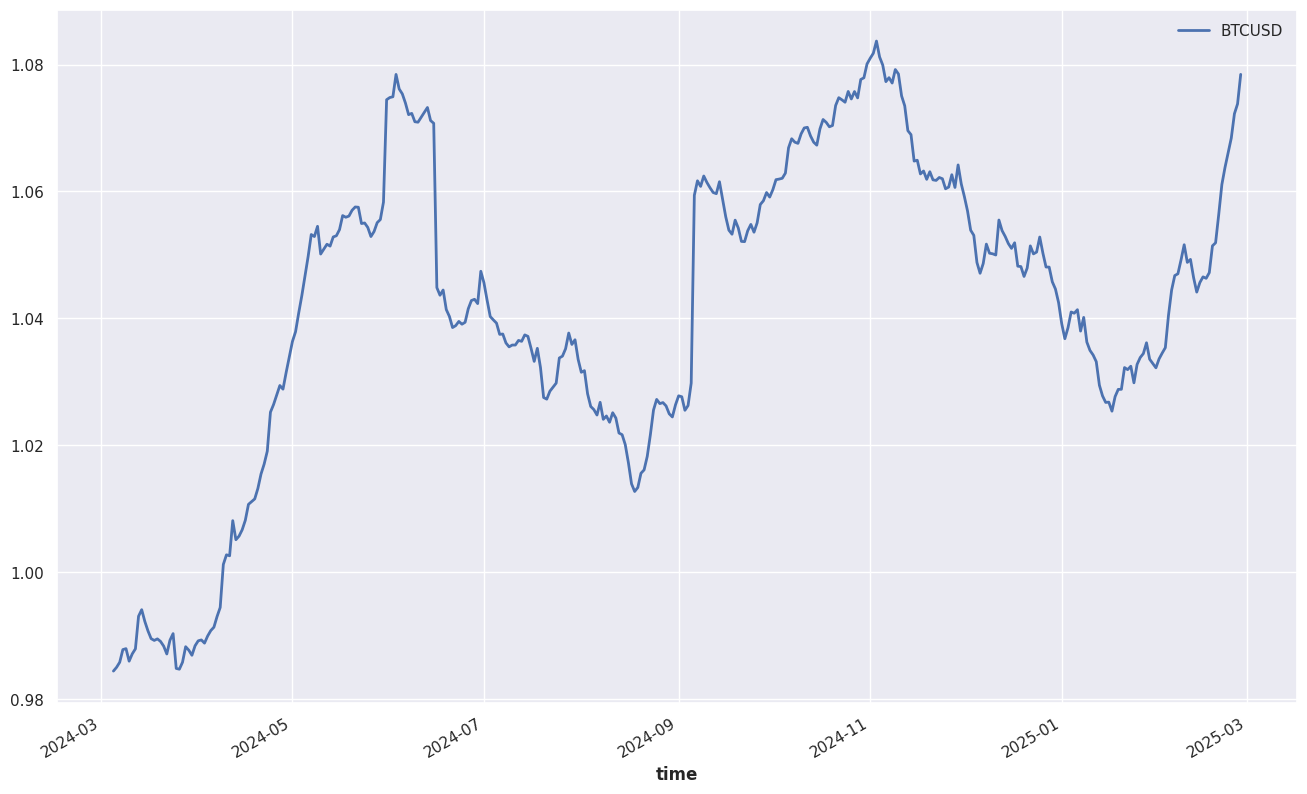

In [11]:
# %matplotlib notebook
%matplotlib inline

train_plot = train.tail(30)
forecast_len = ocl
forecast_len = round(360*1)


fig, ax = plt.subplots(figsize=(16,9))

# pred = m.predict(n=1)
# pred = m.predict(len(val), past_covariates=past_covariates)

# ValueError: `num_samples > 1` is only supported for probabilistic models.
# pred = m.predict(forecast_len, num_samples=1)
# pred = m.predict(forecast_len, future_covariates=future_covariates)
pred = m.predict(forecast_len)

# train_plot.plot() # -----------------------------------------------<<<<
pred.plot(label=ticker, low_quantile=0.05, high_quantile=0.95)
plt.legend()


# y.plot(label='actual')
# pred.plot(label='forecast')
# plt.legend();
# print('MAPE = {:.2f}%'.format(mape(y, pred)))


In [12]:
# val.to_csv(exportPath + 'val.csv')
# val_df = pd.read_csv(exportPath + 'val.csv',parse_dates = True,index_col=0)

pred.to_csv(exportPath + 'pred.csv')
pred_df = pd.read_csv(exportPath + 'pred.csv',parse_dates = True,index_col=0)
# c_sma = tmp_df.y.rolling(10,center=False,min_periods=1).mean()
# _ma = pred_df.y.rolling(10,center=False,min_periods=1).mean()
_ma = savgol(pred_df)






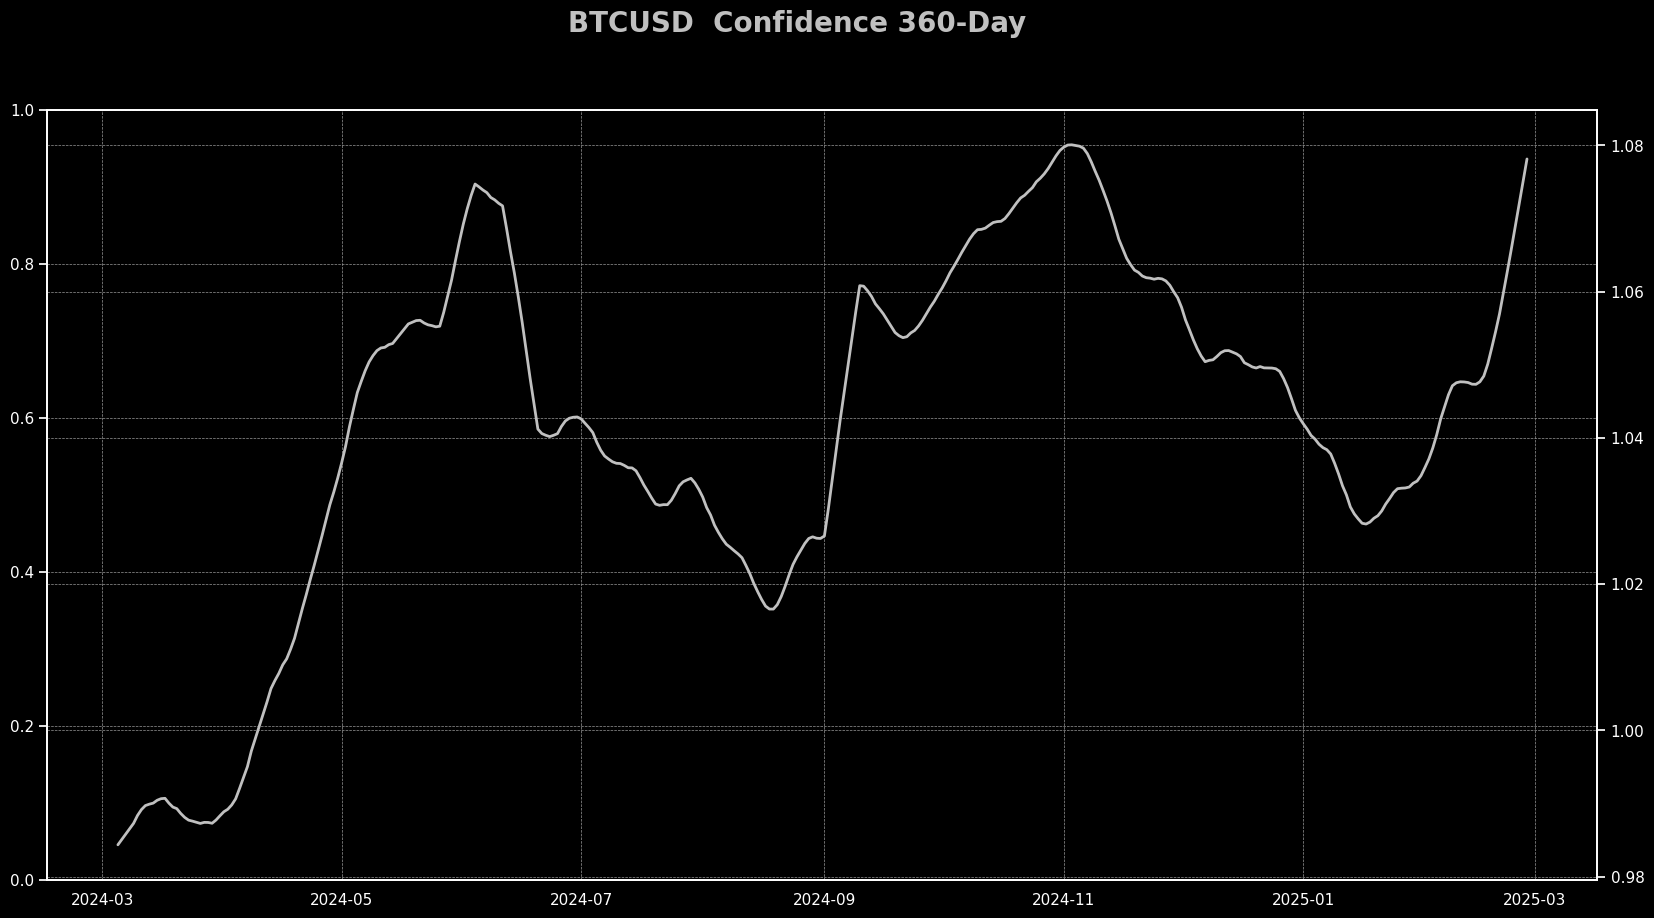

In [13]:
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties

# prop = FontProperties(fname='/usr/share/fonts/noto/NotoColorEmoji.ttf')
# plt.rcParams['font.family'] = prop.get_family()


# Set a dark style for the plot
plt.style.use('dark_background')

# Create a figure with two subplots that share the same x-axis
fig, ax1 = plt.subplots(figsize=(20, 10), sharex=True)
ax2 = ax1.twinx()

color_ax1 = '#00FF00'
color_ax2 = '#C0C0C0'

# Plot time series 1 on ax1 with a vibrant color
# ax1.plot(pred_df['y'], linewidth=2, color=color_ax1, label="Pred")
# ax1.set_ylabel('Pred', color=color_ax1)

# Plot time series 2 on ax2 with a different vibrant color
ax2.plot(_ma, linewidth=2, color=color_ax2, label="SAVGOL")
# ax2.set_ylabel('SAVGOL', color=color_ax2)

title = ticker + "  " + 'Confidence ' + str(forecast_len) + '-' + res
# title = str(forecast_len) + '-' + res
# title = 
# Set a title for the entire figure
fig.suptitle(title, fontsize=20, fontweight="bold", color="#C0C0C0")

# Set a grid on both axes with a lighter gray color
grid_style = {'linewidth': 0.5, 'color': '#999999', 'linestyle': '--'}
ax1.grid(True, **grid_style)
ax2.grid(True, **grid_style)

# Add a legend for both axes with a white font color
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines += lines2
labels += labels2

# fig.legend(lines, labels, loc='upper right', facecolor='black', edgecolor='white', fontsize=12)

plt.savefig(imgPath + title + '.png', dpi=300, bbox_inches='tight', facecolor='black')

plt.show()
